## This notebook is part of the Apache Spark training delivered by CERN-IT
### Spark SQL Hands-On Lab with Solutions
Contact: Luca.Canali@cern.ch

Run this notebook from Jupyter with Python kernel
- When using on CERN SWAN, do not attach the notebook to a Spark cluster, but rather run locally on the SWAN container
- If running this outside CERN SWAN, plese make sure to tha PySpark installed: `pip install pyspark`

## Examples datasets
The following examples use sample data provided in the repository.  
We will use the movielens dataset from Kaggle, credits: https://www.kaggle.com/grouplens/movielens-20m-dataset

In [ ]:
# Create Spark Session, you need this to work with Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("My spark example app")  \
        .master("local[*]") \
        .config("spark.driver.memory","8g") \
        .config("spark.ui.showConsoleProgress", "false") \
        .getOrCreate()

In [2]:
spark

In [3]:
# sets the path to the directory with datafiles
PATH = "../data/"

In [4]:
ratings = spark.read.option("header","true").csv(PATH + "ratings1.csv.gz")

In [5]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
+------+-------+------+----------+
only showing top 5 rows



In [6]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [7]:
# infer schema needs to go through the data to estimate the schema, this takes time

%time ratings = spark.read.option("header","true").option("inferSchema", "true").csv(PATH + "ratings1.csv.gz")

# note ratings*.csv.gz will read rating1.csv.gz and ratings2.csv.gz, more data, however slower to run
# spark.read.option("header","true").option("inferSchema", "true").csv(PATH + "ratings*.csv.gz")

CPU times: user 7.62 ms, sys: 6.18 ms, total: 13.8 ms
Wall time: 26.9 s


In [8]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [9]:
# movielens dataset
movies = spark.read.option("header","true").option("inferSchema", "true").csv(PATH + "movies.csv.gz")

In [10]:
movies.show(5, False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [11]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [12]:
tags = spark.read.option("header","true").option("inferSchema", "true").csv(PATH + "tags.csv.gz")

In [13]:
tags.show(5)

+------+-------+----------+----------+
|userId|movieId|       tag| timestamp|
+------+-------+----------+----------+
|     1|    318|  narrated|1425942391|
|    20|   4306|Dreamworks|1459855607|
|    20|  89302|   England|1400778834|
|    20|  89302| espionage|1400778836|
|    20|  89302|      jazz|1400778841|
+------+-------+----------+----------+
only showing top 5 rows



#### Register the dataframes as Spark Temporary Views

In [14]:
ratings.createOrReplaceTempView("ratings")
movies.createOrReplaceTempView("movies")
tags.createOrReplaceTempView("tags")

In [15]:
# note what happens when we query a table in a csv file with a filter
spark.sql("select movieId, title from movies where movieId=1").explain()

== Physical Plan ==
*(1) Filter (isnotnull(movieId#85) AND (movieId#85 = 1))
+- FileScan csv [movieId#85,title#86] Batched: false, DataFilters: [isnotnull(movieId#85), (movieId#85 = 1)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/eos/home-c/canali/SWAN_projects/HadoopSparkTraining/Spark/data/m..., PartitionFilters: [], PushedFilters: [IsNotNull(movieId), EqualTo(movieId,1)], ReadSchema: struct<movieId:int,title:string>




In [16]:
# cache the tables, to improve the performance of the rest of the queries in the notebook
# note: default caching level is MEMORY_AND_DISK (i.e. caching in memory if enough heap is available)
# note: caching is lazily executed, so a count() action is added to make the operation happen
# this operation may take a couple of minutes

r = ratings.cache().count()
m = movies.cache().count()
t = tags.cache().count()

In [17]:
print(f"Num ratings = {r}\nNum tags = {t}\nNum movies = {m}")

Num ratings = 13012144
Num tags = 753170
Num movies = 45843


### SQL Queries on the loaded tables
#### 1) How many movies produced per year?

In [18]:
# Add the column Year to "movies"
movies_year = spark.sql("select *, regexp_extract(title,'^(.*) \\\\(([0-9 \\\\-]*)\\\\)$',2) as Year from movies")
movies_year.show(5,False)
movies_year.createOrReplaceTempView("movies_year")

# This is the DataFrame API equivalent, not that \\ oddly need to be changed to \\\\\ when using SQL, at least in this version of Spark
# from pyspark.sql.functions import regexp_extract
# movies_year = movies.withColumn("Year",regexp_extract("title",'^(.*) \\(([0-9 \\-]*)\\)$',2))

+-------+----------------------------------+-------------------------------------------+----+
|movieId|title                             |genres                                     |Year|
+-------+----------------------------------+-------------------------------------------+----+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995|
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995|
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995|
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995|
+-------+----------------------------------+-------------------------------------------+----+
only showing top 5 rows



In [19]:
# number of movies per year
m_yr = spark.sql("select year, count(1) as count from movies_year group by year order by year").toPandas()

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-darkgrid')

<IPython.core.display.Javascript object>


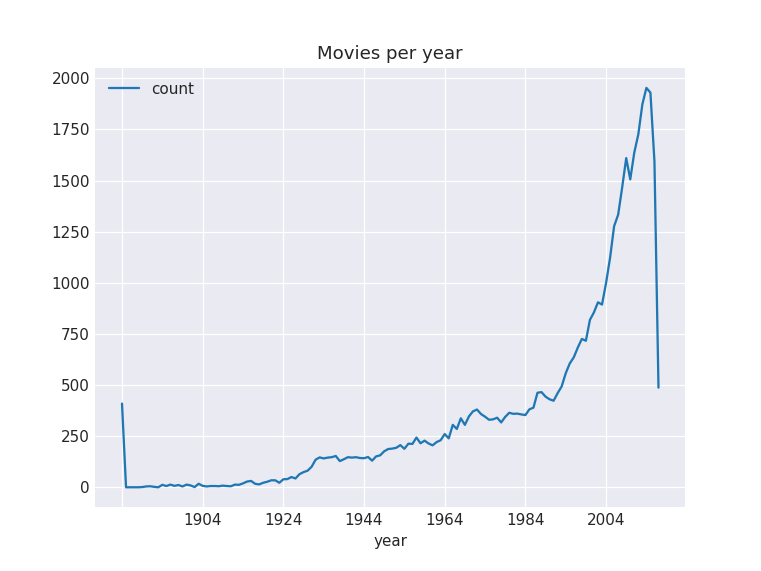

In [21]:
m_yr.plot(x='year',y='count',kind='line', title='Movies per year');

#### 2) Top movies by number of ratings

In [22]:
# A query to perform a join operation between movies and ratings
# Find the highest rated movies

spark.sql("""
select title, count(*) 
from movies m, ratings r 
where m.movieId = r.movieId
group by title 
order by 2 desc""").limit(5).toPandas()

,title,count(1)
0,Forrest Gump (1994),45782
1,"Shawshank Redemption, The (1994)",45546
2,Pulp Fiction (1994),43755
3,"Silence of the Lambs, The (1991)",41807
4,"Matrix, The (1999)",38860


#### What happened in the background? How did the join happen?
#### How is the query executed? Can we get more information?

In [23]:
spark.sql("""
select title, count(*) 
from movies m, ratings r 
where m.movieId = r.movieId
group by title 
order by 2 desc""").explain(True)

== Parsed Logical Plan ==
'Sort [2 DESC NULLS LAST], true
+- 'Aggregate ['title], ['title, unresolvedalias('count(1), None)]
   +- 'Filter ('m.movieId = 'r.movieId)
      +- 'Join Inner
         :- 'SubqueryAlias m
         :  +- 'UnresolvedRelation [movies], [], false
         +- 'SubqueryAlias r
            +- 'UnresolvedRelation [ratings], [], false

== Analyzed Logical Plan ==
title: string, count(1): bigint
Sort [count(1)#866L DESC NULLS LAST], true
+- Aggregate [title#86], [title#86, count(1) AS count(1)#866L]
   +- Filter (movieId#85 = movieId#62)
      +- Join Inner
         :- SubqueryAlias m
         :  +- SubqueryAlias movies
         :     +- View (`movies`, [movieId#85,title#86,genres#87])
         :        +- Relation [movieId#85,title#86,genres#87] csv
         +- SubqueryAlias r
            +- SubqueryAlias ratings
               +- View (`ratings`, [userId#61,movieId#62,rating#63,timestamp#64])
                  +- Relation [userId#61,movieId#62,rating#63,timestamp#64]

#### 3) Highly rated movies
Find the top 5 highly rated movies

In [24]:
spark.sql("""select title, avg(rating) as avg_rating from movies m, ratings r
            where m.movieId = r.movieId
            group by title
            order by 2 desc""").show(5, False)

+-----------------------------------+----------+
|title                              |avg_rating|
+-----------------------------------+----------+
|The Hardy Bucks Movie (2013)       |5.0       |
|Naked Souls (1996)                 |5.0       |
|Paul Goodman Changed My Life (2011)|5.0       |
|Jimi Plays Berkeley (2012)         |5.0       |
|Punk in London (1977)              |5.0       |
+-----------------------------------+----------+
only showing top 5 rows



#### Drill down on the top entries:
   - How many reviews contributed to this rating?

In [25]:
spark.sql("""select title, avg(rating) as avg_rating, count(*) as count from movies m, ratings r
            where m.movieId = r.movieId
            group by title
            order by 2 desc""").show(5, False)

+-----------------------------------+----------+-----+
|title                              |avg_rating|count|
+-----------------------------------+----------+-----+
|The Hardy Bucks Movie (2013)       |5.0       |1    |
|Naked Souls (1996)                 |5.0       |1    |
|Paul Goodman Changed My Life (2011)|5.0       |1    |
|Jimi Plays Berkeley (2012)         |5.0       |1    |
|Punk in London (1977)              |5.0       |1    |
+-----------------------------------+----------+-----+
only showing top 5 rows



Lets only take in account movies that have more than 100 reviews

In [26]:
spark.sql("""select title, avg(rating) as avg_rating, count(*) as count from movies m, ratings r
            where m.movieId = r.movieId
            group by title
            having count(*) > 100
            order by 2 desc""").limit(20).toPandas()

,title,avg_rating,count
0,Planet Earth (2006),4.467391,368
1,Band of Brothers (2001),4.431655,139
2,"Shawshank Redemption, The (1994)",4.426338,45546
3,"Godfather, The (1972)",4.335648,28582
4,"Usual Suspects, The (1995)",4.299494,29635
5,"Godfather: Part II, The (1974)",4.266718,18319
6,Seven Samurai (Shichinin no samurai) (1954),4.265507,6900
7,Schindler's List (1993),4.261945,33780
8,The Blue Planet (2001),4.234615,130
9,Fight Club (1999),4.232034,29931


#### 4) Find the top rated movie of every year since 2000

In [27]:
avg_ratings = spark.sql("""select year, title, round(avg(rating),2) as avg_rating, count(*) as count
                           from movies_year m, ratings r where m.movieId = r.movieId 
                           group by year, title
                           having count(*) > 100""")

avg_ratings.createOrReplaceTempView("avg_ratings")

# note this is just the definition of a helper view
# because of lazy execution no query is run at this step

In [28]:
# the query for top-rated movies is run here, triggered by the action to show the first 20 rows

spark.sql("""select a.year, a.title, avg_rating from avg_ratings a,
            (select year, max(avg_rating) as max_rating from avg_ratings group by year) m
            where a.year = m.year
            and a.avg_rating = m.max_rating
            and a.year > 2000
            order by year""").show(20, False)

+----+--------------------------------------------------------------------------+----------+
|year|title                                                                     |avg_rating|
+----+--------------------------------------------------------------------------+----------+
|2001|Band of Brothers (2001)                                                   |4.43      |
|2002|City of God (Cidade de Deus) (2002)                                       |4.19      |
|2003|Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)|4.11      |
|2003|Lord of the Rings: The Return of the King, The (2003)                     |4.11      |
|2004|Voices from the List (2004)                                               |4.15      |
|2005|49 Up (2005)                                                              |4.06      |
|2006|Planet Earth (2006)                                                       |4.47      |
|2007|Like Stars on Earth (Taare Zameen Par) (2007)                   

In [29]:
# End the Spark application
spark.stop()